# Exploring Onboarding Data from Operate First Repos

One of the goals of this team is to establish the Operate First community cloud as the go-to platform for incubating open servies. We believe that improving the user experience as well as the SRE experience would go a long way in achieving that goal. To that end, in this quarter we want to implement a service catalog, and put some automatation in place to improve the onboarding process.

Now in order to concretely measure the effects of these efforts, we need to establish some evaluation metrics or key performance indicators. This notebook explores what is the kind and volume of data that can be collected from the GitHub repos where onboarding activites take place. Then, it explores some possible metrics that could be used to quantify the "time to onboard".

In [1]:
import re
from typing import List
from dotenv import find_dotenv, load_dotenv
from IPython.display import display, Markdown

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

# load env vars
load_dotenv(find_dotenv())

# NOTE: GitHub PAT needs to exist as env var before importing the srcopmetrics
# this is a known bug of this library
from srcopsmetrics.entities.issue import Issue  # noqa: E402
from srcopsmetrics.entities.pull_request import PullRequest  # noqa: E402

In [2]:
# default pretty graph settings
sns.set()

## Collect All Issue + PR Data

First, we'll use Thoth's MI tool to collect all issues and pull requests related to onboarding. Because of how the repos are set up, the `support` repo is where the operate-first users create issues, and the `apps` repo is where the manifests are stored (and hence pull requests would be made here). So we'll collect issues from `support` repo, and pull requests from `apps` repo.

In [3]:
ISSUES_ORG_REPO = "operate-first/support"
PRS_ORG_REPO = "operate-first/apps"

In [4]:
# !python -m srcopsmetrics.cli --create-knowledge --is-local --repository $ISSUES_ORG_REPO --entities PullRequest

In [5]:
# !python -m srcopsmetrics.cli --create-knowledge --is-local --repository $PRS_ORG_RPEO --entities PullRequest

## GitHub Issues related to Onboarding

In [6]:
# load issue data using an entity, put it into df
issue_entity = Issue("operate-first/support")
issues_df = issue_entity.load_previous_knowledge(is_local=True)
issues_df = issues_df.reset_index()
issues_df.head()

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions
0,575,Deploy curator-operator in Smaug cluster,Earlier we have deployed the curator project i...,skanthed,2022-05-18 23:12:21,None,NaT,{},{'dystewart': 1}
1,573,[smaug] opf-jupyterhub namespace has reached i...,None,4n4nd,2022-05-05 18:53:29,HumairAK,2022-05-05 19:01:01,"{'area/service/odh': {'color': 'fc05d7', 'labe...","{'4n4nd': 1, 'first-operator[bot]': 75}"
2,572,"As the stakeholder (sig-data-science), I want ...",- [ ] determine if definitions in doc make sen...,HumairAK,2022-05-03 19:15:14,None,NaT,{},{}
3,571,"As an OPF admin / PO, I want to define the ""ti...",- [ ] define the metric (issue_close - issue_o...,HumairAK,2022-05-03 19:08:44,None,NaT,"{'kind/user-story': {'color': '1D76DB', 'label...",{'HumairAK': 19}
4,570,public operations project board,### Description\n\nI'm interested in being abl...,erikerlandson,2022-05-03 02:20:16,erikerlandson,2022-05-03 20:19:19,"{'kind/question': {'color': 'd455d0', 'labeled...","{'HumairAK': 14, 'erikerlandson': 3}"


In [7]:
# lets take a look at what labels are used
labels_on_issue = issues_df["labels"].apply(lambda x: list(x.keys()))

# flatten list of lists and remove duplicates
unique_labels = list(
    set([lab for labellist in labels_on_issue.values for lab in labellist])
)

unique_labels[:5]

['kind/onboarding', 'help wanted', 'sig/devops', 'blocked', 'lifecycle/rotten']

In [8]:
# how many times has each set of labels been used
display(
    Markdown(
        "### How often (percent of issues) does each label combination occur?",
    )
)
labels_on_issue.value_counts(normalize=True)

### How often (percent of issues) does each label combination occur?

[]                                                                                                       0.278119
[onboarding]                                                                                             0.079755
[lifecycle/stale, lifecycle/rotten]                                                                      0.063395
[kind/onboarding]                                                                                        0.055215
[lifecycle/stale]                                                                                        0.051125
                                                                                                           ...   
[kind/feature, priority/important-soon, lifecycle/frozen, triage/accepted]                               0.002045
[kind/bug, priority/important-soon, area/user, human_intervention_required, priority/critical-urgent]    0.002045
[kind/onboarding, priority/important-soon, lifecycle/stale, lifecycle/rotten]           

**NOTE** Looks like ~28% of the issues don't have any labels at all. So it might be worth it to use some basic heuristics to manually check if any of these label-less issues are related to onboarding and thus relevant to our analysis.

### Side Quest: Are Label-less Issues Relevant?

In [9]:
# filter to get labelless issues
labelless_filter = issues_df["labels"].apply(len) == 0
labelless_issues_df = issues_df[labelless_filter].sort_values(
    "created_at", ascending=False
)
labelless_issues_df.head()

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions
0,575,Deploy curator-operator in Smaug cluster,Earlier we have deployed the curator project i...,skanthed,2022-05-18 23:12:21,None,NaT,{},{'dystewart': 1}
2,572,"As the stakeholder (sig-data-science), I want ...",- [ ] determine if definitions in doc make sen...,HumairAK,2022-05-03 19:15:14,None,NaT,{},{}
16,558,Username changed and removed access to ressources,**Describe the bug**\r\nIt looks like my usern...,PixelJonas,2022-04-21 12:35:33,HumairAK,2022-05-02 20:20:58,{},{'HumairAK': 27}
21,552,Authentication error when accessing OS-Climate...,**Describe the bug**\r\nUnable to log into htt...,tumido,2022-04-06 16:02:01,tumido,2022-04-07 01:44:19,{},"{'HumairAK': 72, 'harshad16': 5, 'tumido': 7}"
22,551,[TASK] Better use of Github Labels to scope is...,**User story**\r\nIt would be nice to make bet...,Gregory-Pereira,2022-04-02 03:05:59,None,NaT,{},{'quaid': 13}


**NOTE** Looks like these are pretty recent issues, so we can rule out the possiblity that "they lack labels because labels weren't defined at the time of issue creation". So maybe it's worth it to dive a bit deeper.

In [10]:
# lets see if the title or body contains anything related to onboarding
onboard_filter = labelless_issues_df["body"].str.lower().str.contains(
    "onboard"
) | labelless_issues_df["title"].str.lower().str.contains("onboard")
labelless_issues_df[onboard_filter]

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions
24,547,[TASK] Update the issue and bug templates,**User story**\r\nWith many changes having occ...,Gregory-Pereira,2022-03-28 22:31:12,None,NaT,{},"{'HumairAK': 101, 'Gregory-Pereira': 32}"
187,368,[TASK] Provision a cluster for DevConf US 2021...,Zero is not stable enough for a workshop and S...,tumido,2021-08-30 15:25:39,tumido,2021-09-02 02:19:04,{},{'tumido': 1}
191,364,Support for multiple buckets in Trino and acce...,**Is your feature request related to a problem...,HumairAK,2021-08-26 17:35:45,HumairAK,2021-09-10 17:45:48,{},"{'HumairAK': 43, 'erikerlandson': 27}"
207,345,"Issue Template ""Onboard to Continuous Deployme...",**Describe the bug**\r\n\r\nThe issue template...,rbo,2021-08-08 14:09:23,tumido,2021-10-01 04:11:30,{},"{'HumairAK': 10, 'rbo': 18, 'tumido': 3}"
208,344,Update Rick cluster to 4.8.2,"Before onboarding of users, we should try to u...",rbo,2021-08-08 13:50:27,sesheta,2021-10-07 19:24:56,{},"{'tumido': 16, 'rbo': 8}"
218,333,Onboard OS Climate to Operate First,This issue to identify the tools/services that...,HumairAK,2021-08-04 18:57:45,HumairAK,2021-10-07 18:05:47,{},"{'HumairAK': 45, 'erikerlandson': 50, 'durando..."
251,292,[TASK] Convert issue templates to issue forms,**User story**\r\nIssue forms are a new fancy ...,tumido,2021-06-30 16:16:04,tumido,2021-10-11 10:57:33,{},"{'HumairAK': 6, 'tumido': 3}"
372,149,Onboarding rbohne to zero,**Describe the bug**\r\nAfter login into the z...,rbo,2021-03-25 15:13:30,sesheta,2021-03-31 22:35:46,{},"{'tumido': 80, 'rbo': 197, 'durandom': 193, 'H..."
390,129,feat: Make onboarding issue template clearer/e...,We need the onboarding to cluster template a l...,HumairAK,2021-03-16 23:56:25,sesheta,2021-03-19 16:24:29,{},{}
394,124,[TASK] Better wording for the README explainin...,**User story**\r\nHeidi:\r\n> There is onboard...,tumido,2021-03-16 16:12:22,HumairAK,2021-07-07 15:56:13,{},{'HumairAK': 215}


**NOTE** We went through these issues manually, and talked to a subject matter expert regarding some of these. We determined that these issues are either not strictly related to onboarding, or, related to onboarding but outliers / one-off special cases. 

### Side Quest Conclusion

Labelless issues do not contain any meaningful information that we want to include in the analysis at this stage. So we can safely skip over these.

In [11]:
# how many times has each label been used
label_freq = labels_on_issue.apply(pd.value_counts)

# need to convert from label name being columns to them being rows
# then sum for each label
label_freq = label_freq.melt().groupby("variable").sum()
label_freq = label_freq.sort_values("value", ascending=False)

display(Markdown("### How often does each specific label occur?"))
label_freq.head()

### How often does each specific label occur?

,value
variable,
lifecycle/stale,165.0
lifecycle/rotten,104.0
onboarding,55.0
kind/onboarding,51.0
kind/feature,43.0


In [12]:
# which ones might be related to onboarding?
label_freq[label_freq.index.str.contains("onboard")]

,value
variable,
onboarding,55.0
kind/onboarding,51.0
onboarding-argocd,1.0


**NOTE** From the unique labels set and from the tables above, it seems like the issues we'd be interested in would have the label `onboarding` or `kind/onboarding`. This has been confirmed after talking to one of our subject matter experts.

In [13]:
# get issues having the onboarding labels
onboard_labels = {"onboarding", "kind/onboarding"}
onboard_filter = issues_df["labels"].apply(
    lambda x: len(onboard_labels.intersection(x.keys())) != 0
)
onboard_issues_df = issues_df.loc[onboard_filter]
onboard_issues_df.head()

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions
7,567,Onboard API Designer,### Target cluster\n\nSmaug\n\n### Team name\n...,riprasad,2022-04-25 22:11:02,HumairAK,2022-05-03 17:19:24,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'riprasad': 107, 'HumairAK': 3}"
15,559,"""smart-village-view""/""openshift-service-ca.crt...",### Requested actions\r\n\r\n#### Resource req...,computate,2022-04-21 18:46:05,computate,2022-04-21 20:45:31,"{'onboarding': {'color': '57bf42', 'labeled_at...",{'computate': 27}
20,553,smart-village-view,### Target cluster\r\n\r\n_No response_\r\n\r\...,computate,2022-04-13 23:31:04,4n4nd,2022-04-20 17:31:56,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'durandom': 7, 'Gregory-Pereira': 24, '4n4nd'..."
26,545,BUCKET: rhosp-cloudops,### Username\n\ncsibbitt\n\n### Desired bucket...,csibbitt,2022-03-23 21:22:18,None,NaT,"{'kind/onboarding': {'color': 'c7def8', 'label...",{}
27,544,NEW PROJECT: rhosp-cloudops,### Target cluster\n\n_No response_\n\n### Tea...,csibbitt,2022-03-23 21:21:43,None,NaT,"{'kind/onboarding': {'color': 'c7def8', 'label...",{}


## GitHub PRs related to Onboarding

In [14]:
# load issue data using an entity, put it into df
pr_entity = PullRequest("operate-first/apps")
prs_df = pr_entity.load_previous_knowledge(is_local=True)
prs_df = prs_df.reset_index()
prs_df.head()

,id,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at
0,796,feat: Move cluster scope overlays around for m...,Supporting: https://github.com/operate-first/h...,XL,tumido,1970-01-19 19:15:53.376,1970-01-19 19:23:09.789,HumairAK,1970-01-19 19:23:09.789,HumairAK,1,94,"{'HumairAK': 6, 'larsks': 1, 'sesheta': 65}","{'695054302': {'author': '4n4nd', 'words_count...","[size/XL, approved, lgtm]",[e0f371d0e4f9a4b20b9461834721476ce61752fc],[cluster-scope/overlays/moc/common/kustomizati...,1970-01-19 19:23:08.639,NaT
1,795,fix: Reorder on-call to keep current schedule,Put Humair all the way to the back (from the f...,XS,tumido,1970-01-19 19:14:43.998,1970-01-19 19:14:50.505,sesheta,1970-01-19 19:14:50.505,sesheta,1,1,{'sesheta': 68},"{'690957553': {'author': '4n4nd', 'words_count...","[approved, size/XS, lgtm]",[f8a6006c6244e5c50236e679df0ce198b06573e7],[slack-first/overlays/moc/zero/secret.enc.yaml],1970-01-19 19:14:44.075,1970-01-19 19:14:44.075
2,794,feat: Downsize JH profiles on CPU,Workaround for: https://github.com/operate-fir...,S,tumido,1970-01-19 19:14:35.744,1970-01-19 19:14:45.325,sesheta,1970-01-19 19:14:45.325,sesheta,1,1,"{'tumido': 6, 'sesheta': 65}","{'690812926': {'author': '4n4nd', 'words_count...","[approved, size/S, lgtm]",[e952fe70304208f1e26e4d5d800683ee47c47062],[odh-manifests/jupyterhub/base/jupyterhub-sing...,1970-01-19 19:14:36.116,1970-01-19 19:14:44.914
3,788,feat: Add new on-call members,Part of: https://github.com/operate-first/SRE/...,S,tumido,1970-01-19 19:14:22.093,1970-01-19 19:14:38.088,sesheta,1970-01-19 19:14:38.088,sesheta,1,2,"{'sesheta': 68, 'tumido': 1}","{'690552033': {'author': 'HumairAK', 'words_co...","[approved, size/S, lgtm]",[c87ce17bc7f893652a1106011bbe052f059f3594],"[slack-first/overlays/moc/zero/config.yaml, sl...",1970-01-19 19:14:23.777,1970-01-19 19:14:23.777
4,787,update thoth dashboards CRDs,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,1970-01-19 19:14:19.821,1970-01-19 19:14:50.077,4n4nd,1970-01-19 19:14:50.077,4n4nd,1,2,"{'HumairAK': 1, 'tumido': 2, 'sesheta': 68, '4...","{'690558711': {'author': 'tumido', 'words_coun...","[approved, size/XS, lgtm]",[1a746f7dad30fa1feace0974f541f7b8a16b5563],[kfdefs/overlays/moc/zero/opf-monitoring/dashb...,1970-01-19 19:14:24.215,1970-01-19 19:14:24.215


In [15]:
# can we determine if a pr was related to onboarding based on any labels?
unique_pr_labels = list(
    set([lab for labellist in prs_df["labels"].values for lab in labellist])
)

unique_pr_labels

['lgtm',
 'sig/devops',
 'lifecycle/rotten',
 'size/S',
 'priority/critical-urgent',
 'needs-ok-to-test',
 'needs-rebase',
 'size/L',
 'workload-overview',
 'monitoring',
 'do-not-merge/work-in-progress',
 'size/XS',
 'approved',
 'ok-to-test',
 'priority/important-soon',
 'size/XL',
 'area/service/argocd',
 'lifecycle/stale',
 'cluster/smaug',
 'do-not-merge/needs-rebase',
 'size/M',
 'jupyterhub',
 'size/XXL',
 'do-not-merge/hold',
 'area/service/odh']

**NOTE** There are no labels that can indicate whether a PR addresses an onboarding issue or not. So we'll have to find other ways of determining this.

In [16]:
# lets see if we can link with issues using regex
def find_associated_issue(pr_body: str) -> List[int]:
    if pr_body is not None:
        matches = re.findall("operate-first/support/issues/([0-9]+)", pr_body)
        if len(matches) != 0:
            # print(matches)
            return matches
        else:
            return list()
    return list()


prs_df["associated_issues"] = prs_df["body"].apply(find_associated_issue)

In [17]:
# how many opf support issues does each pr have linked with it
prs_df["associated_issues"].apply(len).value_counts()

0    1442
1     232
2      14
3       1
Name: associated_issues, dtype: int64

In [18]:
# lets only keep the prs which we can directly tell are related to onbarding
onboard_prs_df = prs_df[prs_df["associated_issues"].apply(len) != 0]
onboard_prs_df.head()

,id,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,associated_issues
2,794,feat: Downsize JH profiles on CPU,Workaround for: https://github.com/operate-fir...,S,tumido,1970-01-19 19:14:35.744,1970-01-19 19:14:45.325,sesheta,1970-01-19 19:14:45.325,sesheta,1,1,"{'tumido': 6, 'sesheta': 65}","{'690812926': {'author': '4n4nd', 'words_count...","[approved, size/S, lgtm]",[e952fe70304208f1e26e4d5d800683ee47c47062],[odh-manifests/jupyterhub/base/jupyterhub-sing...,1970-01-19 19:14:36.116,1970-01-19 19:14:44.914,[240]
5,786,feat: Deploy ACME to infra cluster,Part of: https://github.com/operate-first/supp...,S,tumido,1970-01-19 19:13:07.518,1970-01-19 19:13:19.446,sesheta,1970-01-19 19:13:19.446,sesheta,1,2,{'sesheta': 65},"{'689660326': {'author': '4n4nd', 'words_count...","[approved, size/S, lgtm]",[59f0ed316f656c91da4b9ef9664a19928a9fd822],[acme-operator/overlays/moc/infra/issuer-letse...,1970-01-19 19:13:09.871,1970-01-19 19:13:19.132,[282]
8,781,feat: onboard chi-rhug,Resolves: https://github.com/operate-first/sup...,L,tumido,1970-01-19 19:13:03.584,1970-01-19 19:13:19.928,sesheta,1970-01-19 19:13:19.928,sesheta,1,10,{'sesheta': 65},"{'689751858': {'author': '4n4nd', 'words_count...","[size/L, approved, lgtm]",[e62879455aa9aef0d6ecec1629873308bcc0a58b],[cluster-scope/base/core/namespaces/chi-rhug/k...,1970-01-19 19:13:14.148,1970-01-19 19:13:19.615,[279]
9,780,feat: Convert routes with cert to acme-operator,Resolves: https://github.com/operate-first/sup...,M,tumido,1970-01-19 19:13:02.259,1970-01-19 19:15:57.147,sesheta,1970-01-19 19:15:57.147,sesheta,1,7,"{'tumido': 41, 'larsks': 1, 'sesheta': 65}","{'689565850': {'author': '4n4nd', 'words_count...","[size/M, approved, lgtm]",[29ce15750bd39ab4896b8ca79874c7b58ef53485],"[argocd/overlays/moc-infra/kustomization.yaml,...",1970-01-19 19:13:05.655,NaT,[280]
14,775,Fix missing names in additional image streams,Part of: https://github.com/operate-first/supp...,S,tumido,1970-01-19 19:11:40.731,1970-01-19 19:11:41.232,sesheta,1970-01-19 19:11:41.232,sesheta,1,3,{'sesheta': 65},"{'688506957': {'author': '4n4nd', 'words_count...","[approved, size/S, lgtm]",[bcf58456012f6ff3dff042cfea83b35198974e55],[kfdefs/base/jupyterhub/notebook-images/kustom...,1970-01-19 19:11:40.887,1970-01-19 19:11:40.887,[276]


#### FIXME
why are datetime columns in this df not accurate? cant measure time to merge/close pr if this is not available

## Possible Metrics

Now that we have collected all issue and pull request data related to onboarding, let's explore what are some possible evaluation metrics that we could define for the onboarding process.

In [19]:
def get_business_days_diff(row: pd.Series) -> int:
    """
    Get difference in created_at and closed_at in terms of business days
    TODO: exclude US holidays, EU holidays, Red Hat shutdown, etc. from business days
    """
    if not pd.isna(row["closed_at"]):
        return np.busday_count(row["created_at"].date(), row["closed_at"].date())


# calculate business days taken to close
onboard_issues_df["time_to_close_busdays"] = onboard_issues_df.apply(
    get_business_days_diff, axis=1
)
onboard_issues_df["time_to_close_busdays"]

# summary stats
onboard_issues_df["time_to_close_busdays"].describe()

/tmp/ipykernel_1667970/3601152953.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onboard_issues_df["time_to_close_busdays"] = onboard_issues_df.apply(


count     91.000000
mean      48.395604
std       64.540406
min        0.000000
25%        1.000000
50%        7.000000
75%       96.000000
max      210.000000
Name: time_to_close_busdays, dtype: float64

**NOTE** Right off the bat we can see that the average time to close issue is ~48 days, which is rather high. This could be an inaccurate measure since mean is sensitive to outliers. The median time to close, ~7 days, seems more reasonable. We can explore these in the following sections.

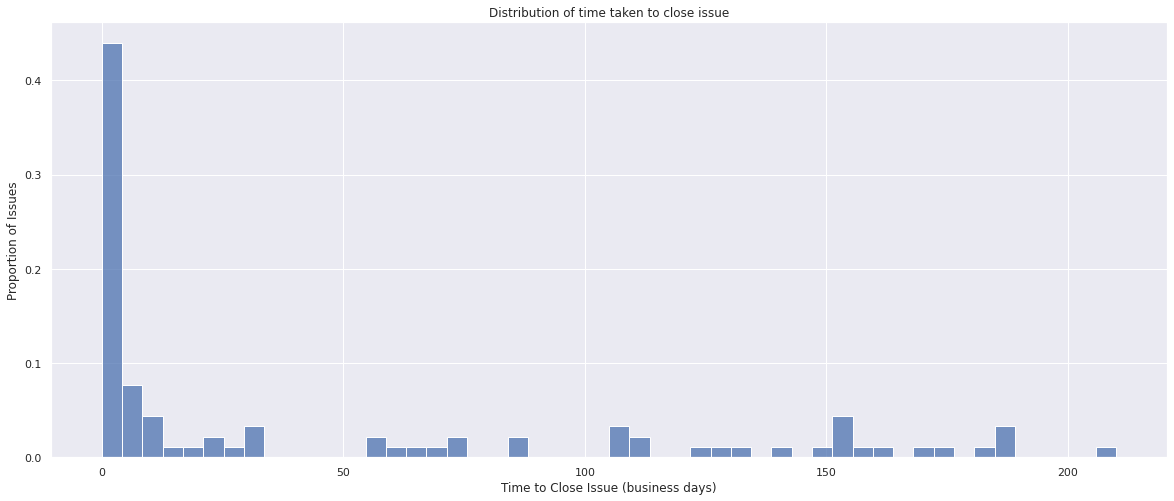

In [20]:
# histogram to visualize distribution of time to close issue
fig, ax = plt.subplots(figsize=(20, 8))
sns.histplot(
    onboard_issues_df["time_to_close_busdays"],
    ax=ax,
    bins=50,
    stat="probability",
)
plt.ylabel("Proportion of Issues")
plt.xlabel("Time to Close Issue (business days)")
plt.title("Distribution of time taken to close issue")
plt.show()

### Side Quest: Did some onboarding tasks really take several months?

There seem to be some issues that took >6 months to resolve. Is this data correct? Was there some particular reason why this was the case?

In [21]:
# closing time between 3 and 6 months
onboard_issues_df[
    (onboard_issues_df["time_to_close_busdays"] > 90)
    & (onboard_issues_df["time_to_close_busdays"] <= 180)
]

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions,time_to_close_busdays
94,472,Form recognition,### Target cluster\n\nSmaug\n\n### Team name\n...,rh-tmichels,2021-11-10 17:06:31,sesheta,2022-04-09 21:07:40,"{'kind/onboarding': {'color': 'c7def8', 'label...",{'sesheta': 144},108.0
95,470,PROJECT: b4mad-ipfs,### Select all that apply\n\n- [ ] Create a ne...,goern,2021-11-09 19:38:23,sesheta,2022-05-02 00:10:18,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'goern': 1, 'sesheta': 144, 'HumairAK': 15}",124.0
96,469,NEW PROJECT: b4mad-ipfs,### Target cluster\n\nRick\n\n### Team name\n\...,goern,2021-11-09 19:34:51,sesheta,2022-04-09 03:07:38,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'HumairAK': 13, 'sesheta': 144}",109.0
169,387,Export log data sample for anomaly detection s...,### Requested actions\r\nI kindly ask you to p...,dhonza,2021-09-15 21:03:32,sesheta,2022-02-19 00:34:34,"{'onboarding': {'color': '57BF42', 'labeled_at...","{'durandom': 12, 'sesheta': 144, '4n4nd': 28}",113.0
176,379,NEW PROJECT: access logs for investigation reg...,### Requested actions\r\n\r\nI am Yolanda from...,yrobla,2021-09-06 11:52:42,sesheta,2022-02-06 23:24:29,"{'onboarding': {'color': '57BF42', 'labeled_at...","{'durandom': 15, 'sesheta': 144}",110.0
184,371,BUCKET: weech,### Username\n\neldritchjs\n\n### Desired buck...,EldritchJS,2021-08-31 23:15:33,sesheta,2022-03-27 00:06:33,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'tumido': 21, 'sesheta': 144}",149.0
206,346,Onboard to argocd examples-openshift-pub,### Requested actions\r\n\r\nSelect all that a...,rbo,2021-08-08 14:16:17,sesheta,2022-04-10 21:07:47,"{'onboarding': {'color': '57BF42', 'labeled_at...",{'sesheta': 215},175.0
209,343,NEW PROJECT: examples-openshift-pub on rick,### Target cluster\r\n\r\nMorty\r\n\r\n### Tea...,rbo,2021-08-08 13:35:36,rbo,2022-03-11 21:21:24,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'tumido': 8, 'sesheta': 144, 'rbo': 2}",154.0
211,341,NEW PROJECT: builder ( demo onboarding for sim...,### Target cluster\r\n\r\nMorty\r\n\r\n### Tea...,rbo,2021-08-08 13:24:24,rbo,2022-03-11 21:13:39,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'sesheta': 144, 'rbo': 2}",154.0
215,337,NEW PROJECT: Sandiego,### Target cluster\r\n\r\nZero\r\n\r\n### Team...,cdolfi,2021-08-05 22:26:05,Gregory-Pereira,2022-03-09 22:11:48,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'cdolfi': 82, 'tumido': 83, '4n4nd': 32, 'ses...",154.0


In [22]:
# closing time greater than 6 months
onboard_issues_df[onboard_issues_df["time_to_close_busdays"] > 180]

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions,time_to_close_busdays
348,177,A project to automate onboarding,### Questionnaire\r\n\r\n1. TARGET CLUSTER: ze...,rob-baron,2021-03-30 20:50:13,sesheta,2021-12-13 08:17:55,"{'onboarding': {'color': '57BF42', 'labeled_at...","{'rob-baron': 308, 'durandom': 105, 'msdisme':...",184.0
350,176,operate first a pulp+python_plugin instance (o...,```feature\r\nFeature: op1st is operating one ...,goern,2021-03-29 19:56:49,sesheta,2022-01-17 22:51:30,"{'onboarding': {'color': '57BF42', 'labeled_at...","{'tumido': 1957, 'fridex': 2824, 'fao89': 401,...",210.0
351,174,Deploy KFServing on Operate First,**Is your feature request related to a problem...,pacospace,2021-03-29 18:27:03,sesheta,2021-12-14 14:18:05,"{'onboarding': {'color': '57BF42', 'labeled_at...","{'tumido': 47, 'pacospace': 85, 'moficodes': 5...",186.0
354,171,Manage APIs with 3Scale,### Requested actions\r\n\r\nDeploy 3Scale API...,fridex,2021-03-29 14:39:43,sesheta,2021-12-13 05:17:53,"{'onboarding': {'color': '57BF42', 'labeled_at...","{'tumido': 81, 'fridex': 139, 'sesheta': 144}",185.0
355,169,moc-reporting,### Questionnaire\r\n\r\n1. reporting\r\n\r\n ...,rob-baron,2021-03-27 02:20:10,sesheta,2021-12-13 05:17:51,"{'onboarding': {'color': '57BF42', 'labeled_at...","{'tumido': 32, 'rob-baron': 95, 'HumairAK': 50...",185.0


### Side Quest Conclusion

From what I can tell, most of the above seem to be legitimate cases of onboarding, and looks like they actually have been unresolved for the given amount of time (**_but should be confirmed with an SME!!!_**). So cannot be excluded from our analysis, at least for now.

### Mean Time to Close Issues Created Till Now

For each issue, we will calculate the timedelta between issue created_at and issue closed_at. At each point in time, the `Mean Time to Close Issue Till Now` is the average time taken to close all issues that were created up until that point in time.

In [23]:
# calculate running mean of time to close
# i.e. average of time taken to close all issues that were created from beginning of time till current date (created_at)
mttc_till_now = (
    onboard_issues_df.sort_values(by="created_at")["time_to_close_busdays"]
    .expanding()
    .mean()
)
mttc_till_now = mttc_till_now.rename("mttc_till_now")

# merge with rest of df
onboard_issues_df = onboard_issues_df.merge(
    mttc_till_now,
    left_index=True,
    right_index=True,
)
onboard_issues_df.head()

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions,time_to_close_busdays,mttc_till_now
7,567,Onboard API Designer,### Target cluster\n\nSmaug\n\n### Team name\n...,riprasad,2022-04-25 22:11:02,HumairAK,2022-05-03 17:19:24,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'riprasad': 107, 'HumairAK': 3}",6.0,48.395604
15,559,"""smart-village-view""/""openshift-service-ca.crt...",### Requested actions\r\n\r\n#### Resource req...,computate,2022-04-21 18:46:05,computate,2022-04-21 20:45:31,"{'onboarding': {'color': '57bf42', 'labeled_at...",{'computate': 27},0.0,48.866667
20,553,smart-village-view,### Target cluster\r\n\r\n_No response_\r\n\r\...,computate,2022-04-13 23:31:04,4n4nd,2022-04-20 17:31:56,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'durandom': 7, 'Gregory-Pereira': 24, '4n4nd'...",5.0,49.415730
26,545,BUCKET: rhosp-cloudops,### Username\n\ncsibbitt\n\n### Desired bucket...,csibbitt,2022-03-23 21:22:18,None,NaT,"{'kind/onboarding': {'color': 'c7def8', 'label...",{},NaN,49.920455
27,544,NEW PROJECT: rhosp-cloudops,### Target cluster\n\n_No response_\n\n### Tea...,csibbitt,2022-03-23 21:21:43,None,NaT,"{'kind/onboarding': {'color': 'c7def8', 'label...",{},NaN,49.920455


/home/kachau/.local/share/virtualenvs/metrics-tEPVQzGW/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


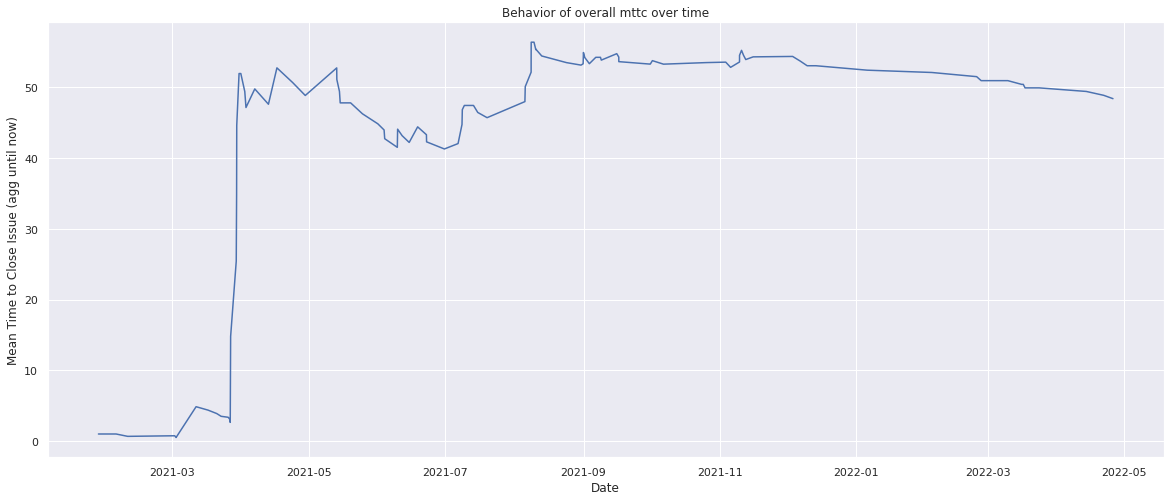

In [24]:
# what does the mean time  to close till now look like, over time
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(onboard_issues_df["created_at"], onboard_issues_df["mttc_till_now"])
plt.ylabel("Mean Time to Close Issue (agg until now)")
plt.xlabel("Date")
plt.title("Behavior of overall mttc over time")
plt.show()

### Median Time to Close Issues Created Till Now

Since we saw that mean is sensitive to outliers, lets see if running median makes more sense. That is, we define the `Median Time to Close Issue Till Now` at a given point in time as the median of the time taken to close all issues that were created up until that point in time.

In [25]:
# calculate running median of time to close
# i.e. average of time taken to close all issues that were created from beginning of time till current date (created_at)
med_ttc_till_now = (
    onboard_issues_df.sort_values(by="created_at")["time_to_close_busdays"]
    .expanding()
    .median()
)
med_ttc_till_now = med_ttc_till_now.rename("med_ttc_till_now")

# merge with rest of df
onboard_issues_df = onboard_issues_df.merge(
    med_ttc_till_now,
    left_index=True,
    right_index=True,
)
onboard_issues_df.head()

,id,title,body,created_by,created_at,closed_by,closed_at,labels,interactions,time_to_close_busdays,mttc_till_now,med_ttc_till_now
7,567,Onboard API Designer,### Target cluster\n\nSmaug\n\n### Team name\n...,riprasad,2022-04-25 22:11:02,HumairAK,2022-05-03 17:19:24,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'riprasad': 107, 'HumairAK': 3}",6.0,48.395604,7.0
15,559,"""smart-village-view""/""openshift-service-ca.crt...",### Requested actions\r\n\r\n#### Resource req...,computate,2022-04-21 18:46:05,computate,2022-04-21 20:45:31,"{'onboarding': {'color': '57bf42', 'labeled_at...",{'computate': 27},0.0,48.866667,7.5
20,553,smart-village-view,### Target cluster\r\n\r\n_No response_\r\n\r\...,computate,2022-04-13 23:31:04,4n4nd,2022-04-20 17:31:56,"{'kind/onboarding': {'color': 'c7def8', 'label...","{'durandom': 7, 'Gregory-Pereira': 24, '4n4nd'...",5.0,49.415730,8.0
26,545,BUCKET: rhosp-cloudops,### Username\n\ncsibbitt\n\n### Desired bucket...,csibbitt,2022-03-23 21:22:18,None,NaT,"{'kind/onboarding': {'color': 'c7def8', 'label...",{},NaN,49.920455,9.0
27,544,NEW PROJECT: rhosp-cloudops,### Target cluster\n\n_No response_\n\n### Tea...,csibbitt,2022-03-23 21:21:43,None,NaT,"{'kind/onboarding': {'color': 'c7def8', 'label...",{},NaN,49.920455,9.0


/home/kachau/.local/share/virtualenvs/metrics-tEPVQzGW/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


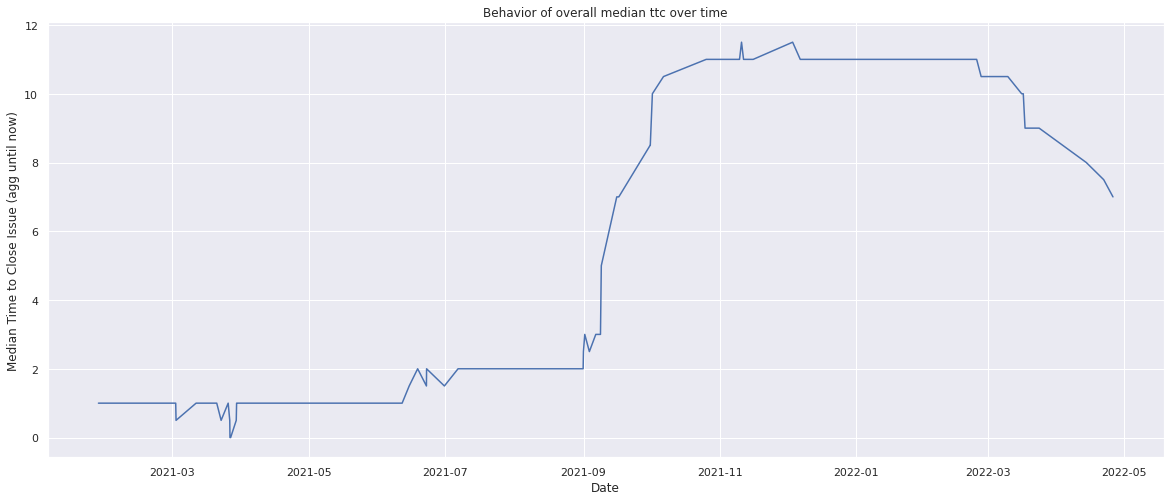

In [26]:
# what does the median time to close till now look like, over time
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(onboard_issues_df["created_at"], onboard_issues_df["med_ttc_till_now"])
plt.ylabel("Median Time to Close Issue (agg until now)")
plt.xlabel("Date")
plt.title("Behavior of overall median ttc over time")
plt.show()

### Mean Time to Close Issues Created in Last 2 Weeks

It seems that mean of time taken to close issues from beginning of time to now is skewed due to some issues that were blocked because of resources or other blockers. Lets define `Previous 2 Week Mean Time to Close Issue` at a point in time as, the average of time taken to close issues that were opened in the last two weeks (one sprint length).

In [27]:
# resample to one sprint (~14 days)
time_to_close_2week = onboard_issues_df[
    ["created_at", "time_to_close_busdays"]
].set_index("created_at")
time_to_close_2week = time_to_close_2week.resample("2W").mean()
time_to_close_2week.tail()

,time_to_close_busdays
created_at,
2022-03-06,2.5
2022-03-20,6.0
2022-04-03,NaN
2022-04-17,5.0
2022-05-01,3.0


**NOTE** This looks more reasonable as there would be periods of time when we are blocked by external factors and overall mean/median TTC would be high, and then there would be normal periods of time when we are unblocked and mean/median TTC is lower.

/home/kachau/.local/share/virtualenvs/metrics-tEPVQzGW/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


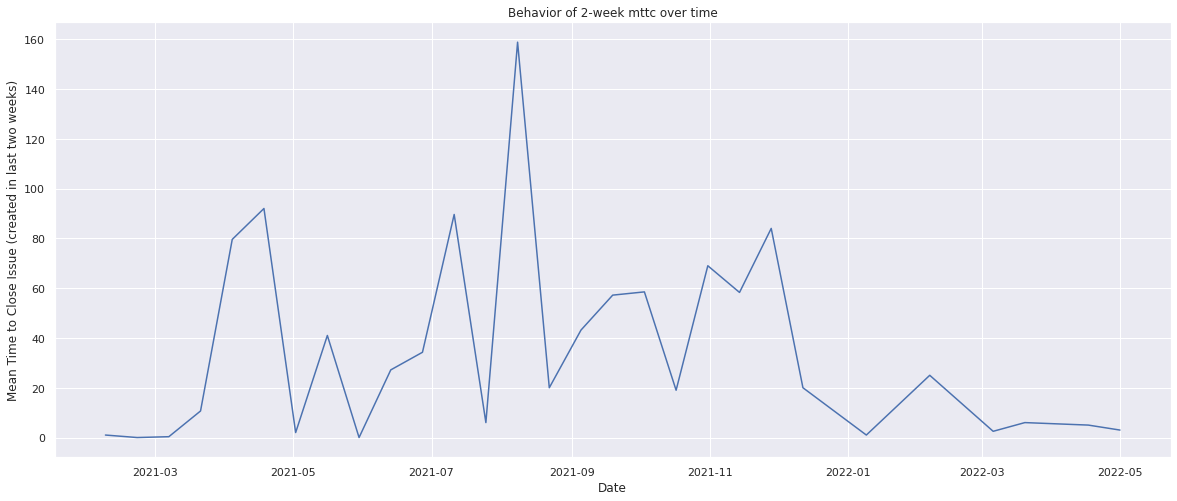

In [28]:
# what does the mean time  to close till now look like, over time
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(
    time_to_close_2week["time_to_close_busdays"].index,
    time_to_close_2week["time_to_close_busdays"].values,
)
plt.ylabel("Mean Time to Close Issue (created in last two weeks)")
plt.xlabel("Date")
plt.title("Behavior of 2-week mttc over time")
plt.show()

# Conclusion

In this notebook, we showed how to collect issue and PR data for onboarding activities. Then we explored some possible metrics that can be used as key performance indicators for the onboarding process. Out of these, mean time to close issues created in the last two weeks seems the most reasonable.